In [214]:
from collections import defaultdict
import awkward as ak
import numba
import numpy as np
import pandas as pd
import h5py
import vector
vector.register_numba()
vector.register_awkward()

import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#import mplhep as hep
#hep.style.use(hep.style.ROOT)

from sklearn.metrics import roc_auc_score, roc_curve

In [215]:
filename_test="/afs/cern.ch/user/r/ramellar/public/inputs_files/spanet_classification/output_JetGood_test.h5"
filename_pred="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_nobtag_class_prediction.h5"
filename_pred_nobtag_mass="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_nobtag_class_prediction.h5"

df_test = h5py.File(filename_test,'r')
df_pred = h5py.File(filename_pred,'r')
df_pred_no_btag_mass = h5py.File(filename_pred_nobtag_mass,'r')


In [216]:
#define signal events
mask_signal=df_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
#define background events
mask_background=df_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0

probabilities_signal=df_pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]

print(probabilities_signal)

[0.9218046  0.21281077 0.7761503  ... 0.8011484  0.5468575  0.565303  ]


In [217]:
proba_signal_signal=probabilities_signal[mask_signal]
proba_signal_background=probabilities_signal[mask_background]

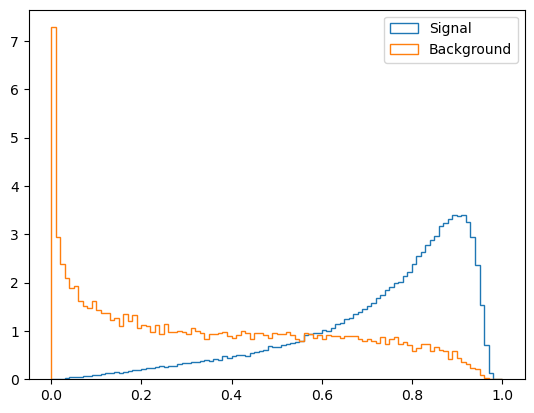

In [218]:
plt.hist(proba_signal_signal,bins=100,range=(0,1),histtype='step',label="Signal", density=True)
plt.hist(proba_signal_background,bins=100,range=(0,1),histtype='step',label="Background", density=True)
plt.legend()
plt.show()

[0.9218046  0.21281077 0.7761503  ... 0.8011484  0.5468575  0.565303  ]
[0.         0.         0.         ... 0.99369844 0.99369844 1.        ]


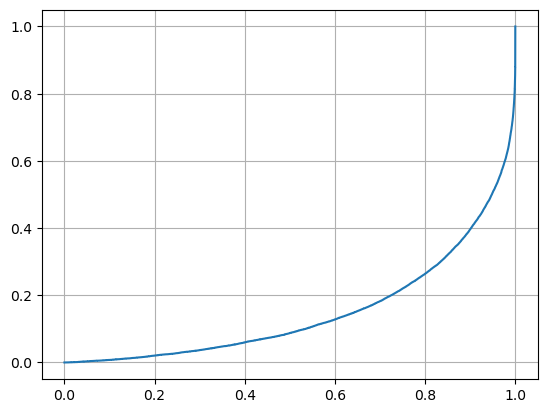

In [219]:
true=df_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]
roc_auc_score(true,probabilities_signal)
print(probabilities_signal)

len(true)

fpr, tpr, thresholds = roc_curve(true, probabilities_signal)

print(fpr)

plt.plot(tpr,fpr)
plt.grid()
plt.show()

In [220]:
len(true)

np.sum((true))/len(true)

0.8656630800418811

In [221]:
roc_auc_score(true,probabilities_signal)

0.8499854946231099

In [222]:
def probabilities(dataset_test, dataset_pred):
    mask_signal=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
    mask_background=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
    prob_signal=dataset_pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
    proba_signal_signal=prob_signal[mask_signal]
    proba_signal_background=prob_signal[mask_background]
    
    plt.hist(proba_signal_signal,bins=100,range=(0,1),histtype='step',label="Signal", density=True)
    plt.hist(proba_signal_background,bins=100,range=(0,1),histtype='step',label="Background", density=True)
    plt.legend()
    plt.show()
    return proba_signal_signal, proba_signal_background

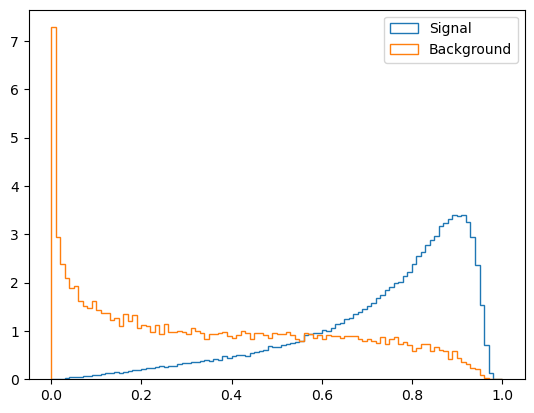

(array([0.9218046 , 0.21281077, 0.7761503 , ..., 0.8011484 , 0.5468575 ,
        0.565303  ], dtype=float32),
 array([6.5230942e-01, 3.8265264e-01, 1.7678326e-01, ..., 2.8059617e-01,
        8.8663048e-01, 2.7490797e-04], dtype=float32))

In [223]:
probabilities(df_test, df_pred_no_btag_mass)

In [224]:
def roc_curve_plot(test_dataset, dataset_pred):
    true=test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    print(true)
    proba_signal=dataset_pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
    print(proba_signal)
    score=roc_auc_score(true, proba_signal)
    print(score)
    fpr, tpr, thresholds = roc_curve(true, proba_signal)
    plt.plot(tpr,fpr,label=f"AUC={score}")
    plt.legend()
    plt.xlabel("tpr")
    plt.ylabel("fpr")
    plt.show()

[1 1 1 ... 1 1 1]
[0.9218046  0.21281077 0.7761503  ... 0.8011484  0.5468575  0.565303  ]
0.8499854946231099


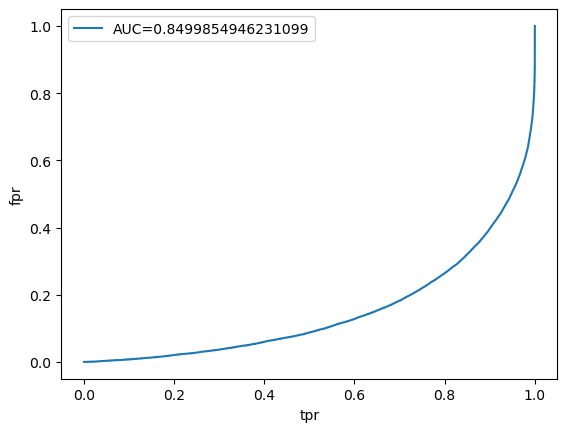

In [225]:
roc_curve_plot(df_test,df_pred)

In [226]:
print(fpr)
print(tpr)
print(thresholds)

[0.         0.         0.         ... 0.99369844 0.99369844 1.        ]
[0.00000000e+00 6.43355744e-06 1.28671149e-04 ... 9.99993566e-01
 1.00000000e+00 1.00000000e+00]
[          inf 9.8435032e-01 9.7723573e-01 ... 1.9562079e-04 1.9516697e-04
 4.4855633e-06]


In [227]:
np.sum(proba_signal_signal >0.5)/len(proba_signal_signal)

0.859774182134011

In [229]:
np.sum(proba_signal_background >0.5)/len(proba_signal_background)

0.33402429418349155

In [231]:
np.argmax(thresholds < 0.5)
fpr[np.argmax(thresholds < 0.5)]
tpr[np.argmax(thresholds < 0.5)]

0.8598449512658024